# Resaercher Evaluation - H-index

# 説明

## h-index（h指数）とは何か？

h-indexはアメリカの物理学者Jorge E. Hirsch氏が2005年に発表した研究者の評価指標である。

> 要旨：私は、研究者の科学的産出を特徴づける有用な指標として、被引用数がhより大きい論文の数と定義される指数hを提案した。
> 
>> Abstract: I propose the index h, defined as the number of papers with citation number ≥h, as a useful index to characterize the scientific output of a researcher. 
> 
> Hirsch, J. E. (2005). An index to quantify an individual's scientific research output. Proceedings of the National Academy of Sciences, 102(46), 16569-16572. https://www.pnas.org/doi/abs/10.1073/pnas.0507655102

ある科学者が発表したN本論文の中で、**h回以上引用された論文がh本あり**、それ以外のN-h本論文の被引用数が全部hより小さい場合、その科学者の**h-indexはh**である。
 
例えば、h-index=**20**というのは、被引用数が**20**以上の論文が**20**本あり、それ以外の論文はすべて被引用数が20本未満だということである。

## なぜ提案したのか？どうして重要なのか？

リソースが限られた世界で、個人の科学的成果の累積的影響力を定量化することは、評価や比較のために必要とされる。

|指数|長所|短所|
|:-|:-|:-|
|発表論文数(N)|研究者の生産力を測る|論文の影響力が無視される|
|総被引用数(C)|研究者の総影響力を測る|1. 少数の大ヒット論文に歪まれる可能性があり、特に、これらの大ヒットが共著である場合、個人のキャリア全体を代表していない可能性がある。<br>2. 引用度の高いレビューに過度な重みを与えている。|
|平均被引用数(C/N)|異なる年齢の科学者を比較することができる|1. 生産性が高い研究者に不利になる。2. 高被引用数の論文に歪まれる可能性がある。|
|被引用数≥cの論文数|上記の指標の欠点を克服し、広範囲かつ持続的な影響を測る。|cは任意であり、一部の科学者に有利な一方で他の科学者には不利になる。|
|上位q個の論文の被引用数|上記の指標の欠点をほとんど克服する。|1. 単一の数値ではないため、科学者を比較するには困難である。<br>2. qは任意であり、一部の科学者に有利な一方で他の科学者には不利になる。|


# 算出

## １. とある研究者Aのh-indexの計算方法

The h-index of the researcher is: 3


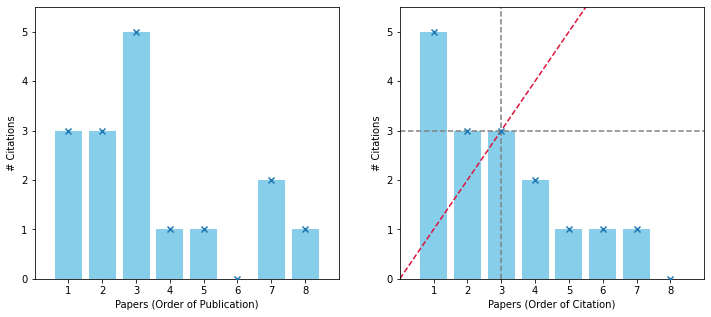

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_c_test(ax, citations, xlabel='Papers', ylabel='# Citations'):
    ax.bar(np.arange(1, len(citations) + 1), citations, color='skyblue')
    ax.scatter(np.arange(1, len(citations) + 1), citations, marker='x', zorder=5)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(1, len(citations) + 1, 1))
    ax.set_xlim(0, len(citations) + 1)
    ax.set_ylim(0, max(citations) * 1.1)

# とある研究者の論文の被引用数を入力
c_test = [3,3,5,1,1,0,2,1]

# 被引用数を大きい順に並べ替える
sorted_c_test = sorted(c_test,reverse=True)

# h-indexの算出
# メソッド１：被引用数が論文のランキングより大きい論文を数える。
h_index = np.sum([c >= i + 1 for i, c in enumerate(sorted_c_test)])

# メソッド２：図に示したように、論文被引用数の曲線と45°直線の交点の横座標がh-index。
array = np.arange(1,len(sorted_c_test)+1)
h_index = np.max(np.minimum(sorted_c_test, array))

print("The h-index of the researcher is:", h_index)

# Plot graphs
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plot_c_test(axs[0], c_test, 'Papers (Order of Publication)', '# Citations')
plot_c_test(axs[1], sorted_c_test, 'Papers (Order of Citation)', '# Citations')
axs[1].plot([0, 10], [0, 10], ls="--", color='crimson')
axs[1].plot([0, axs[1].get_xlim()[1]], [h_index, h_index], color='gray', linestyle='--')
axs[1].plot([h_index, h_index], [0, axs[1].get_ylim()[1]], color='gray', linestyle='--')
plt.show()

## 2. 実データからh-indexの算出

In [ ]:
%pip install pyalex

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
from pyalex import Works, Authors, Sources
import matplotlib.pyplot as plt
import pyalex
import requests

# pyalex.config.email = "your@email.address"
pyalex.config.email = "wangsiyuan1209@gmail.com"

def calculate_h_index(citations):
    citations = np.array(citations)
    citations[::-1].sort()
    array = np.arange(1,citations.size+1)
    h_index = np.max(np.minimum(citations, array))
    return h_index

def plot_citations(ax, citations, xlabel='Papers', ylabel='# Citations', *, h_index=0, loglog=True):
    ax.plot(np.arange(1, len(citations) + 1), citations, marker='o', linestyle='None')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(1, len(citations) + 1, 1))
    if loglog:
        ax.set_yscale('log')  # Set y-axis to log scale
        ax.set_xscale('log')  # Set x-axis to log scale
    lim=min(ax.get_xlim()[1],ax.get_ylim()[1])
    ax.plot([0, lim], [0, lim], ls="--", color='crimson')
    if h_index!=0:
        ax.plot([0, ax.get_xlim()[1]], [h_index, h_index], color='gray', linestyle='--')
        ax.plot([h_index, h_index], [0, ax.get_ylim()[1]], color='gray', linestyle='--')
        plt.show()

def get_all_citations(works_url):
    works_url += '&page={}'
    citations = []
    
    page = 1
    has_more_pages = True
    fewer_than_10k_results = True

    # loop through pages
    while has_more_pages and fewer_than_10k_results:

        # set page value and request page from OpenAlex
        url = works_url.format(page)
        page_with_results = requests.get(url).json()

        # loop through partial list of results
        # extract citation count from every work
        results = page_with_results['results']
        for work in results:
            
            openalex_id = work['id'].replace("https://openalex.org/", "")
            citations.append(work['cited_by_count'])

        # next page
        page += 1

        # end loop when either there are no more results on the requested page 
        # or the next request would exceed 10,000 results
        per_page = page_with_results['meta']['per_page']
        has_more_pages = len(results) == per_page
        fewer_than_10k_results = per_page * page <= 10000
        
    return citations

C:\Users\reinhard\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\reinhard\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
C:\Users\reinhard\AppData\Local\Temp/ipykernel_32788/693747734.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
# アインシュタインを検索する
pager = Authors().search_filter(display_name="albert einstein")\
            .select(["id","display_name","relevance_score","works_count","cited_by_count","summary_stats"])
'''
authors_json = []
for page in pager:
    for item in page:
        authors_json.append(item)
'''     
authors_pd = pd.DataFrame(pager)
display(authors_pd)

author_id = authors_pd.loc[0,"id"]

data = Authors()[author_id]
# display(pd.Series(data)) # 著者データ。
# print(data["works_api_url"]) # 著者の出版データ

author_works_url=data["works_api_url"]+',is_paratext:false'

NameError: name 'Authors' is not defined

In [ ]:
citations = get_all_citations(author_works_url)
id="https://openalex.org/A5054034686"
result = Works().filter(authorships={"author":{"id":id}}).select(["cited_by_count"]).get()

--> The specified researcher has an h-index of 78.


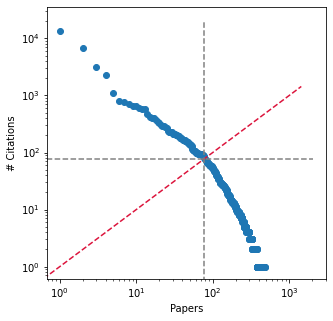

In [ ]:
citations=np.array(citations)
citations[::-1].sort()
# modified binary search
h_index = calculate_h_index(citations)
print(f'--> The specified researcher has an h-index of {h_index}.')

fig, ax = plt.subplots(figsize=(5, 5))
plot_citations(ax, citations, h_index=h_index, loglog=True)
plt.show()

# 探索

In [ ]:
import numpy as np
import pandas as pd
from pprint import pprint
from sklearn.linear_model import LinearRegression

pager = Authors().filter(cited_by_count=">10").sample(1000, seed=42)\
                .select(['id','display_name','works_count','cited_by_count','summary_stats','affiliations','counts_by_year'])\
                .paginate(method="page", per_page=200)

author_json = []
for page in pager:
    for item in page:
        author_json.append(item)

author_training = pd.DataFrame(author_json)
display(author_training)

,id,orcid,display_name,display_name_alternatives,relevance_score,works_count,cited_by_count,summary_stats,ids,affiliations,last_known_institution,last_known_institutions,x_concepts,counts_by_year,works_api_url,updated_date,created_date
0,https://openalex.org/A5074785474,None,Etienne Lefèvre,[Etienne Lefèvre],1.000000,1,11,"{'2yr_mean_citedness': 0.0, 'h_index': 1, 'i10...",{'openalex': 'https://openalex.org/A5074785474'},[{'institution': {'id': 'https://openalex.org/...,"{'id': 'https://openalex.org/I17866349', 'ror'...","[{'id': 'https://openalex.org/I17866349', 'ror...","[{'id': 'https://openalex.org/C2524010', 'wiki...","[{'year': 2023, 'works_count': 0, 'cited_by_co...",https://api.openalex.org/works?filter=author.i...,2023-12-24T05:55:31.646985,2023-07-21
1,https://openalex.org/A5073704210,None,S. Khomiakov,[S. Khomiakov],1.000000,10,145,"{'2yr_mean_citedness': 0.0, 'h_index': 6, 'i10...",{'openalex': 'https://openalex.org/A5073704210'},[{'institution': {'id': 'https://openalex.org/...,"{'id': 'https://openalex.org/I4210136839', 'ro...","[{'id': 'https://openalex.org/I4210136839', 'r...","[{'id': 'https://openalex.org/C127413603', 'wi...","[{'year': 2024, 'works_count': 0, 'cited_by_co...",https://api.openalex.org/works?filter=author.i...,2024-02-10T23:53:22.803250,2023-07-21
2,https://openalex.org/A5001317537,None,Mamadou Diop,"[Mamadou Diop, Diop Mamadou]",1.000000,9,20,"{'2yr_mean_citedness': 4.0, 'h_index': 3, 'i10...",{'openalex': 'https://openalex.org/A5001317537'},[{'institution': {'id': 'https://openalex.org/...,"{'id': 'https://openalex.org/I4210117989', 'ro...","[{'id': 'https://openalex.org/I90183372', 'ror...","[{'id': 'https://openalex.org/C33923547', 'wik...","[{'year': 2023, 'works_count': 0, 'cited_by_co...",https://api.openalex.org/works?filter=author.i...,2024-01-30T04:24:00.429852,2023-07-21
3,https://openalex.org/A5070058857,None,Fariborz Ehteshami,"[Fariborz Ehteshami, F. Ehteshami]",1.000000,29,62,"{'2yr_mean_citedness': 3.0, 'h_index': 4, 'i10...",{'openalex': 'https://openalex.org/A5070058857'},[{'institution': {'id': 'https://openalex.org/...,"{'id': 'https://openalex.org/I4210141426', 'ro...","[{'id': 'https://openalex.org/I4210141426', 'r...","[{'id': 'https://openalex.org/C86803240', 'wik...","[{'year': 2024, 'works_count': 0, 'cited_by_co...",https://api.openalex.org/works?filter=author.i...,2024-02-17T06:35:22.128537,2023-07-21
4,https://openalex.org/A5069641681,None,M. Kubešová,"[Marta Kubešová, M. Kubešová, M.O. Kubesova]",1.000000,7,112,"{'2yr_mean_citedness': 0.0, 'h_index': 4, 'i10...",{'openalex': 'https://openalex.org/A5069641681'},[{'institution': {'id': 'https://openalex.org/...,"{'id': 'https://openalex.org/I3124161356', 'ro...","[{'id': 'https://openalex.org/I3124161356', 'r...","[{'id': 'https://openalex.org/C86803240', 'wik...","[{'year': 2023, 'works_count': 0, 'cited_by_co...",https://api.openalex.org/works?filter=author.i...,2024-02-12T01:29:39.958347,2023-07-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,https://openalex.org/A5043548548,https://orcid.org/0000-0003-2069-2027,Jesús Zepeda–Cervantes,"[Jesús Zepeda‐Cervantes, Jesús Zepeda–Cervante...",0.999944,16,351,"{'2yr_mean_citedness': 8.7, 'h_index': 7, 'i10...",{'openalex': 'https://openalex.org/A5043548548...,[{'institution': {'id': 'https://openalex.org/...,"{'id': 'https://openalex.org/I8961855', 'ror':...","[{'id': 'https://openalex.org/I8961855', 'ror'...","[{'id': 'https://openalex.org/C86803240', 'wik...","[{'year': 2024, 'works_count': 0, 'cited_by_co...",https://api.openalex.org/works?filter=author.i...,2024-02-15T03:41:20.476080,2023-07-21
996,https://openalex.org/A5038820885,https://orcid.org/0000-0002-7897-1670,Engy T. Said,"[Engy T. Said, Engy Tadros Said, Engy Said, E....",0.999944,73,604,"{'2yr_mean_citedness': 1.7916666666666667, 'h_...",{'openalex': 'https://openalex.org/A5038820885...,[{'institution': {'id': 'https://openalex.org/...,"{'id': 'https://openalex.org/I36258959'

"\n# 説明変数と目的変数を定義する\n\nX = data[['feature1', 'feature2', 'feature3', ...]]  # 説明変数\ny = data['target']  # 目的変数\n\n# モデルの初期化\nmodel = LinearRegression()\n\n# モデルをデータに適合させる\nmodel.fit(X, y)\n"